In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
!pip install wordcloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
path = (r"C:\Users\wensen\Desktop\Fordham\Web analyst\1000TripSmith.csv")
Df = pd.read_csv(path)
df=Df.dropna()
df

Date  Rate                                              Title  \
0      5-Dec-21  50.0                                           so good!   
2     28-Nov-21  50.0                           Highly recommended place   
4      8-Nov-21  50.0                                 Best pankajes ever   
6     31-Oct-21  50.0            Great service and food and a fine menul   
8     23-Oct-21  40.0                                        Upscale Pub   
...         ...   ...                                                ...   
1448  18-Jan-17  30.0                    Average and expensive breakfast   
1450  16-Jan-17  40.0                                        Solo Brunch   
1452  13-Jan-17  50.0  Great NYC local restaurant and bar worth trying!!   
1454  10-Jan-17  40.0                                Great brunch in UWS   
1456   7-Jan-17  40.0  Very good food, plentiful portions, decent win...   

                                                 Review  
0     so good! the mac and cheese is great!! i defin...  
2     This restaurant is a real American bar with ex...  
4     Here you find the best pankakes ever and beyon...  
6     It was a beautiful fall evening and the walk t...  
8     We had dinner here recently and it is a busy p...  
...                                                 ...  
1448  We had breakfast here despite my daughter's re...  
1450  I was looking for a nice place with great revi...  
1452  This restaurant was recommended by the front d...  
1454  I've walked by this place many times but have ...  
1456  As long as you can get past the fact that you ...  

[729 rows x 4 columns]

In [3]:
# components for features reduction
n_components = 5

# number of clusters we want
n_clusters = 5

# covert words into TFIDF metrics
tfidf = TfidfVectorizer(stop_words = 'english')
X_text = tfidf.fit_transform(df['Review'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

   Cluster         0         1         2         3         4
0        3  0.194558 -0.008696  0.199877  0.102126  0.209382
1        0  0.263918  0.013649 -0.091212  0.226444  0.062093
2        0  0.096638 -0.069815  0.045494  0.087516 -0.069867
3        0  0.160654  0.015598  0.021090  0.091999 -0.159075
4        4  0.232816 -0.004144  0.034992 -0.114430  0.042979
         Cluster
Cluster         
0            149
1            112
2            106
3             50
4            312


<AxesSubplot:ylabel='Frequency'>

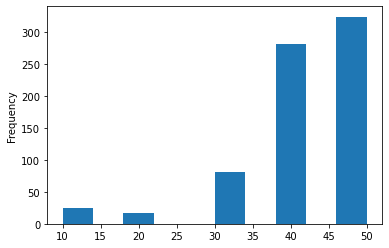

In [4]:
df.Rate.plot(kind = "hist", )

In [5]:
# Logistic Regression approach

df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = df['Review']
    y = df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = 'english')
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d

<ipython-input-5-51e4b4743357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = df_plot['Cluster']


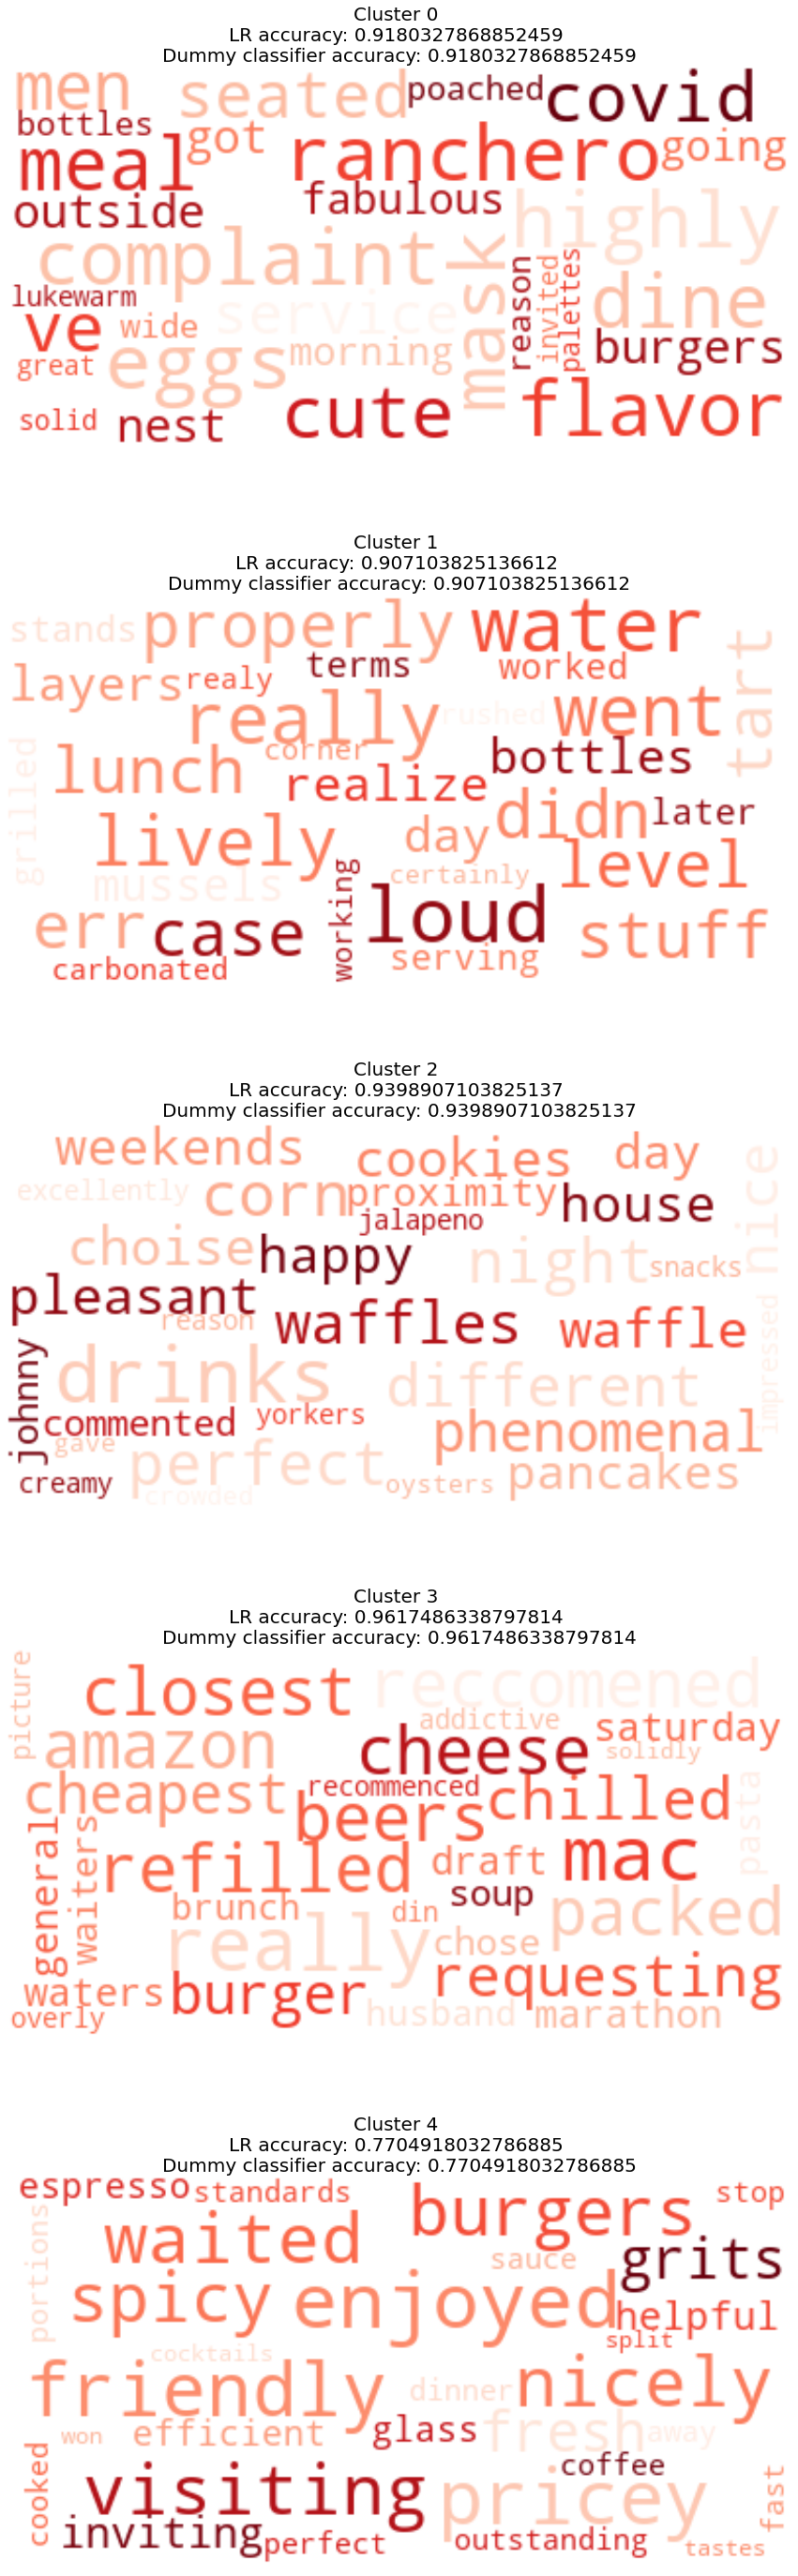

In [6]:
from wordcloud import WordCloud
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False, colormap = 'Reds', background_color = 'white').fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")

<AxesSubplot:ylabel='Frequency'>

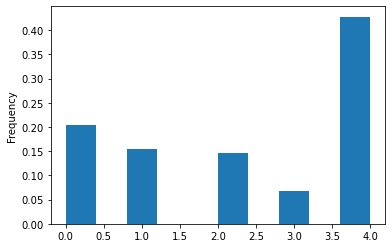

In [7]:
df_plot["Cluster"].plot.hist(weights = np.ones_like(df.index) / len(df.index))

In [8]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [9]:
## Applying Compund score
polarity_scores = df["Review"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

## Applying Sentiment
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

<ipython-input-9-40872a70d0a5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment_Score"] = polarity_scores
<ipython-input-9-40872a70d0a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)


In [10]:
df.head(50)

Date  Rate                                              Title  \
0    5-Dec-21  50.0                                           so good!   
2   28-Nov-21  50.0                           Highly recommended place   
4    8-Nov-21  50.0                                 Best pankajes ever   
6   31-Oct-21  50.0            Great service and food and a fine menul   
8   23-Oct-21  40.0                                        Upscale Pub   
10  21-Oct-21  40.0       Good business lunch spot near Lincoln Center   
12  20-Oct-21  50.0                                    Amazing Burgers   
14  19-Oct-21  40.0                                 Great Italian Food   
16  17-Oct-21  40.0  No need to wear a mask at the location 1150 Br...   
18   7-Oct-21  40.0                                Great avocado toast   
20  27-Sep-21  40.0                Terrific choice near Lincoln Center   
22  26-Sep-21  40.0                                 You can’t go wrong   
24  25-Sep-21  40.0                           A great bar in the apple   
26  14-Sep-21  50.0                            Lovely food and service   
28   7-Sep-21  50.0                               Great place to dine.   
30  22-Aug-21  50.0                                   Delicious Brunch   
32  19-Aug-21  50.0                                   Really Delicious   
34   8-Jul-21  50.0                         Excellent food and dessert   
36   4-Jul-21  50.0                             Great food and service   
38   8-Jun-21  50.0                               Good dependable fare   
40  23-May-21  40.0  The food was great; the service could have bee...   
42   8-May-21  40.0               Great casual spot for American food!   
44  26-Mar-21  50.0                          Food, service, ambiance 👌   
46  25-Mar-21  10.0                        Terribly overrated. Someone   
48   3-Mar-21  40.0                                    Tasty Luncheon!   
50  29-Dec-20  40.0     Lovely place for lunch in Lincoln Center area!   
52   3-Dec-20  10.0                             The smith is overrated   
54  24-Oct-20  40.0                               Lovely outdoor lunch   
56  23-Oct-20  40.0                         Hyper Coronavirus cautious   
58  11-Oct-20  10.0                                         Dirty spot   
60  28-Sep-20  40.0             Amazing food, lots of outdoor seating.   
62  26-Sep-20  10.0  Do not go there, there are several restaurants...   
64  22-Sep-20  30.0                        Uncomfortable outdoor seats   
66  12-Aug-20  30.0                    Great food but drinks expensive   
68  10-Jul-20  50.0                                            Amazing   
70  28-Apr-20  50.0                   Great delivery dinner for 2- $45   
72  12-Apr-20  50.0          The Smith has a great French Bistro feel!   
74   7-Mar-20  50.0                                      Gospel brunch   
76   3-Mar-20  50.0                         Good tasting smart dishes.   
78   1-Mar-20  40.0                                         Nice place   
80  28-Feb-20  20.0                       Watch it if you pay by card.   
82  23-Feb-20  50.0            Fantastic food ,cocktails and cool vibe   
84   9-Feb-20  50.0                                     Very nice food   
86   8-Feb-20  50.0                                  NYC brunch must!!   
88   5-Feb-20  50.0                        Beyond Yummy In Our Tummies   
90   2-Feb-20  40.0    The good food just about balances out the noise   
92  19-Jan-20  40.0                               Try the Bloody Mary!   
94  19-Jan-20  40.0                          Great place for Breakfast   
96  18-Jan-20  50.0                               Excellent experience   
98  16-Jan-20  50.0                                  Excellent seafood   

                                               Review  Cluster  \
0   so good! the mac and cheese is great!! i defin...      3.0   
2   This restaurant is a real American bar with ex...      0.0   
4   Here you find the best pankakes 

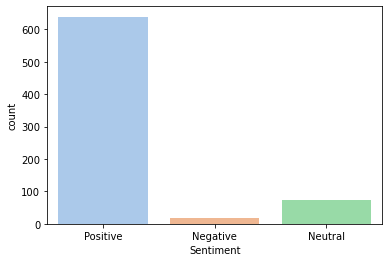

In [11]:
import seaborn as sns
sns.countplot(data=df,x="Sentiment",palette="pastel");

In [12]:
!pip install plotly
import plotly.express as px
# Preparing data for visualization 
Viz_1 = df[['Rate','Sentiment']].value_counts().rename_axis(['Rate','Sentiment']).reset_index(name='counts')

# Plotting the Bar Graph 
fig = px.bar(x=Viz_1.Rate, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'Ratings','y':'Total Number'})
fig.show()

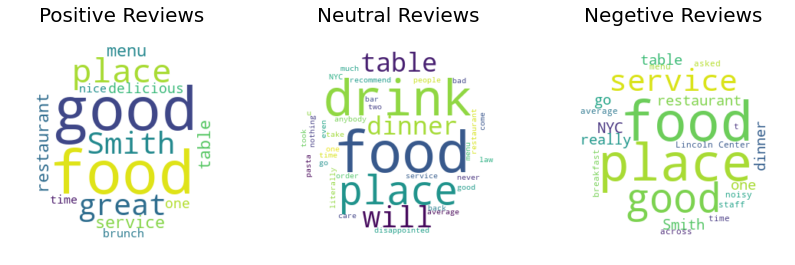

In [13]:
# Getting all the reviews termed positive in a single string and forming a word cloud of the string
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

text1 =''
for i in df[df['Sentiment']=='Positive']['Review'].values:
    text1+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(text1)

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Positive Reviews',fontsize=20);

text2 =''
for i in df[df['Sentiment']=='Negative']['Review'].values:
    text2+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(text2)

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Neutral Reviews',fontsize=20);

text3 =''
for i in df[df['Sentiment']=='Neutral']['Review'].values:
    text3+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(text3)

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Negetive Reviews',fontsize=20);

plt.show()

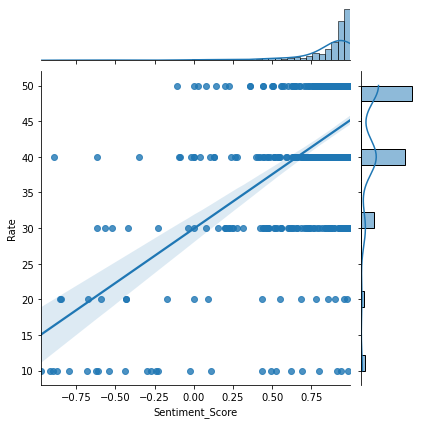

In [14]:
import seaborn as sns
sns.jointplot(data=df, x ="Sentiment_Score",y ="Rate" ,kind="reg")

In [15]:
df

Date  Rate                                              Title  \
0      5-Dec-21  50.0                                           so good!   
2     28-Nov-21  50.0                           Highly recommended place   
4      8-Nov-21  50.0                                 Best pankajes ever   
6     31-Oct-21  50.0            Great service and food and a fine menul   
8     23-Oct-21  40.0                                        Upscale Pub   
...         ...   ...                                                ...   
1448  18-Jan-17  30.0                    Average and expensive breakfast   
1450  16-Jan-17  40.0                                        Solo Brunch   
1452  13-Jan-17  50.0  Great NYC local restaurant and bar worth trying!!   
1454  10-Jan-17  40.0                                Great brunch in UWS   
1456   7-Jan-17  40.0  Very good food, plentiful portions, decent win...   

                                                 Review  Cluster  \
0     so good! the mac and cheese is great!! i defin...      3.0   
2     This restaurant is a real American bar with ex...      0.0   
4     Here you find the best pankakes ever and beyon...      4.0   
6     It was a beautiful fall evening and the walk t...      4.0   
8     We had dinner here recently and it is a busy p...      4.0   
...                                                 ...      ...   
1448  We had breakfast here despite my daughter's re...      NaN   
1450  I was looking for a nice place with great revi...      NaN   
1452  This restaurant was recommended by the front d...      NaN   
1454  I've walked by this place many times but have ...      NaN   
1456  As long as you can get past the fact that you ...      NaN   

      Sentiment_Score Sentiment  
0              0.9163  Positive  
2              0.9333  Positive  
4              0.8880  Positive  
6              0.9638  Positive  
8              0.9917  Positive  
...               ...       ...  
1448           0.7218  Positive  
1450           0.9432  Positive  
1452           0.8582  Positive  
1454           0.9795  Positive  
1456           0.8948  Positive  

[729 rows x 7 columns]

In [16]:
df.corr()

Rate   Cluster  Sentiment_Score
Rate             1.000000 -0.029266         0.557820
Cluster         -0.029266  1.000000        -0.029099
Sentiment_Score  0.557820 -0.029099         1.000000